# Classifying Newswires
## Reuters Dataset

In this report we will be working on the Reuters dataset, which is a set of short newswires and their topics, published by Reuters in 1986. Reuters is a simple, widely used toy dataset for text classification. There are 46 different topics, in which some topics are more represented than others, but each topic has at least 10 examples in the training set. The Reuters dataset comes packaged as part of Keras.

The aim of this project is to build a network to classify Reuters newswires into 46 mutually exclusive topics.
### Hypothesis
- The outputs can be predicted given the inputs
- The available data is sufficiently informative to learn the relationship between inputs and outputs


### Loading the dataset

In [1]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
num_words=10000)

The argument num_words=10000 means we will only keep the top 10,000 most frequesntly occurring words in the training data. This means that rare words will be discarded, as this allows me to work with data of a manageable size.

### I have 8,982 training examples and 2,246 test examples

In [2]:
 len(train_data)

8982

In [3]:
len(test_data)

2246

###  The variables train_data and test_data are lists of topics; each topic is a list of word indices (encoding a sequence of words)

In [4]:
train_data[[10]]

array([list([1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12])],
      dtype=object)

 ### Decoding newswires back to text
Here we will be decoding one of the topics back to English words. 

Below, you can see words_index  is a dictionary mapping words to an integer index. The indices are then reversed and the integers are mapped to the words. The topics are decoded, where the indices are offset by 3 because 0, 1 and 2 are reversed indices for 'padding', 'start of sequence' and 'unknown'.
 
 

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

In [6]:
train_labels[10]

3

## Encoding the Data
As we cannot feed lists of integers into a neural network, we will be turning my lists into tensors using one-hot encoding. One hot encoding  For example, turning the sequence [3, 5] into a 10,000 dimensional vector that will be all 0s besides the indices 3 and 5 which will be 1s. Then we can use a Dense layer as the first layer in my network which will be capable of handling floating point vector data.

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    # Creates an all-zero matrix of shape (len(sequences),dimensions)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        #sets specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results
#vectorized training data
x_train = vectorize_sequences(train_data)
#vectorized test data
x_test = vectorize_sequences(test_data)
#vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train,x_train.shape,x_train.ndim

(array([[0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]]),
 (8982, 10000),
 2)

In [8]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)
one_hot_train_labels, one_hot_train_labels.shape, one_hot_train_labels.ndim

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (8982, 46),
 2)

## Building the network
The number of output classes for this dataset is 46 therefore the dimensionality of the output space is much larger than other datasets, such as the IMDb dataset, where it is 2. For this dataset we will be using  64 dimensional intermediate layers to separate the 46 different classes, and will be building and tuning upon this model to see the results.

## Model 1

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

As you can see above, we end the network with a Dense layer of 46, so for each input, the network will output a 46 dimensional vector. This layer also uses softmax activation, which turns the numbers into probabilities that sum to one. The softmax function outputs a vector that represents the probability distributions of the potential outcomes.

### Compiling Model

In [10]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

The rmsprop optimizer is generally a good enough choice for whatever your problem may be, so we will be using that algorithm for this network. The best loss function to use is categorical_crossentropy. This will measure the distance between the probability distribution output and the true distribution of the labels. We can then train the network to output results close to true labels by minimizing the distance between probability distribution and the true distribution.  

### Setting aside a validation set
Setting apart 1000 samples in the training data to use as a validation set.

In [11]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### Training the model

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 32ms/step - loss: 2.5525 - accuracy: 0.5402 - val_loss: 1.7211 - val_accuracy: 0.6460
Epoch 2/20
16/16 [==============================] - 0s 20ms/step - loss: 1.4099 - accuracy: 0.7018 - val_loss: 1.3156 - val_accuracy: 0.7070
Epoch 3/20
16/16 [==============================] - 0s 20ms/step - loss: 1.0442 - accuracy: 0.7823 - val_loss: 1.1236 - val_accuracy: 0.7590
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.8221 - accuracy: 0.8252 - val_loss: 1.0440 - val_accuracy: 0.7780
Epoch 5/20
16/16 [==============================] - 0s 20ms/step - loss: 0.6553 - accuracy: 0.8618 - val_loss: 0.9754 - val_accuracy: 0.7920
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.5237 - accuracy: 0.8884 - val_loss: 0.9289 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 0s 21ms/step - loss: 0.4251 - accuracy: 0.9138 - val_loss: 0.9044 - val_accuracy: 0.8080
Epoch 8/20
16

Here we trained the network for 20 epochs, with a batch size of 512. The batch size defines the number of samples that will be propoagated through the network, which in this case is 512 samples being chosen at random.

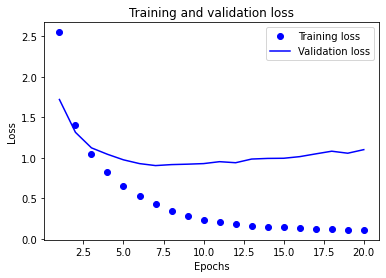

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that the training loss is always decreasing and reaches its best value at the end of the process, despite it being slowed down heavily after the 7th epoch. On the other hand, the validation loss decreases until epoch 8, in which it then declines till the last epoch, meaning this network is overfitting.

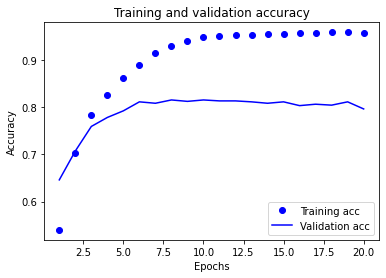

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As you can see the training accuracy increases with every epoch. This is expected when running gradient-descent optimization. The validation accuracy is increasing and reaches its peak validation accuracy of 82% at the 7th epoch. The validation data set then starts to decrease, meaning this network is overfitting. 

## Model 2 - Reducing epochs
For this model we will be reducing the number of epochs from 20 to 9, to try and prevent overfitting.

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(partial_x_train,
            partial_y_train,
            epochs=9,
            batch_size=512,
            validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 0s 29ms/step - loss: 2.4545 - accuracy: 0.5319 - val_loss: 1.6261 - val_accuracy: 0.6440
Epoch 2/9
16/16 [==============================] - 0s 20ms/step - loss: 1.3519 - accuracy: 0.7114 - val_loss: 1.2634 - val_accuracy: 0.7150
Epoch 3/9
16/16 [==============================] - 0s 21ms/step - loss: 1.0189 - accuracy: 0.7795 - val_loss: 1.0991 - val_accuracy: 0.7480
Epoch 4/9
16/16 [==============================] - 0s 21ms/step - loss: 0.8010 - accuracy: 0.8291 - val_loss: 1.0125 - val_accuracy: 0.7820
Epoch 5/9
16/16 [==============================] - 0s 21ms/step - loss: 0.6417 - accuracy: 0.8702 - val_loss: 0.9420 - val_accuracy: 0.8060
Epoch 6/9
16/16 [==============================] - 0s 20ms/step - loss: 0.5117 - accuracy: 0.8956 - val_loss: 0.9101 - val_accuracy: 0.8140
Epoch 7/9
16/16 [==============================] - 0s 20ms/step - loss: 0.4105 - accuracy: 0.9132 - val_loss: 0.9121 - val_accuracy: 0.8030
Epoch 8/9
16/16 [===

For this model we decreased the number of epochs from 20 to 9 to prevent overfitting, an 81% accuracy was still achieved which was good and the validation loss did not start to increase as a result of reducing the epochs.

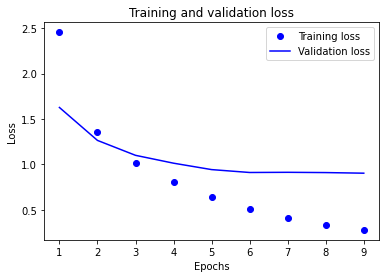

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After reducing the number of epochs to 9, you can see that the training data set is still decreasing, and the loss for the validation data set also decreases until the end however the rate at which it decreases is heavily slowed. Any more epochs and the validation data set would start to increase, so this model is still overfitting.

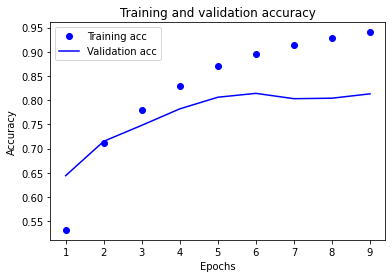

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy increases with every epoch and reaches its peak at 94% at 9 epochs, however the validation dataset reaches its peak of 81% at 6 epochs and then starts to decrease again, eventually hitting 81% again at 9 epochs. Therefore this model is overfitting.



## Model 3 - Adding layers
Adding one extra hidden layer, as well as increasing the first layer unit from 64 to 128.

In [22]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(partial_x_train,
            partial_y_train,
            epochs=9,
            batch_size=512,
            validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 38ms/step - loss: 2.3450 - accuracy: 0.5410 - val_loss: 1.5703 - val_accuracy: 0.6490
Epoch 2/9
16/16 [==============================] - 0s 28ms/step - loss: 1.2681 - accuracy: 0.7224 - val_loss: 1.2382 - val_accuracy: 0.7290
Epoch 3/9
16/16 [==============================] - 0s 29ms/step - loss: 0.9320 - accuracy: 0.7933 - val_loss: 1.0869 - val_accuracy: 0.7670
Epoch 4/9
16/16 [==============================] - 0s 31ms/step - loss: 0.7098 - accuracy: 0.8462 - val_loss: 1.0789 - val_accuracy: 0.7700
Epoch 5/9
16/16 [==============================] - 0s 30ms/step - loss: 0.5363 - accuracy: 0.8815 - val_loss: 0.9879 - val_accuracy: 0.7960
Epoch 6/9
16/16 [==============================] - 0s 29ms/step - loss: 0.4004 - accuracy: 0.9128 - val_loss: 1.0319 - val_accuracy: 0.7810
Epoch 7/9
16/16 [==============================] - 0s 29ms/step - loss: 0.3448 - accuracy: 0.9222 - val_loss: 0.9465 - val_accuracy: 0.8150
Epoch 8/9
16/16 [===

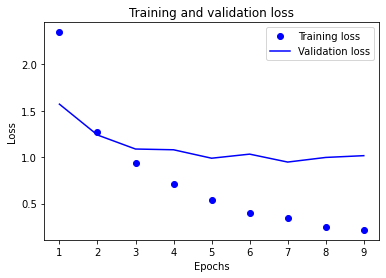

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Changes made in this network, affected the validation loss, it increased to 0.94  at its lowest point, higher by 4% from model 2. The training loss slowly decreases till the end when it hits 21% by epoch 9, considerably lower than model 2, where it reached 27% by epoch 9. This graph is overfitting.

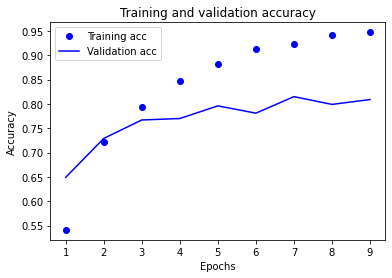

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This graph is very similar to the model 2 accuracy graph. The accuracy for the training data set is almost identical, therefore adding the extra layers and increasing the unit size in the first layer did not make much of a difference. The validation accuracy also fluctuates more but still reaches a good accuracy of 80%. The model is still overfitting.

## Model 4 - Removing layers
For this model, we will be removing one of the hidden layers, so only one hidden layer remains, continuing on from the last model with the same number of epochs, 9.

In [19]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(partial_x_train,
            partial_y_train,
            epochs=9,
            batch_size=512,
            validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 0s 29ms/step - loss: 2.6190 - accuracy: 0.5451 - val_loss: 1.8744 - val_accuracy: 0.6510
Epoch 2/9
16/16 [==============================] - 0s 20ms/step - loss: 1.5179 - accuracy: 0.7176 - val_loss: 1.3708 - val_accuracy: 0.7250
Epoch 3/9
16/16 [==============================] - 0s 20ms/step - loss: 1.0897 - accuracy: 0.7860 - val_loss: 1.1413 - val_accuracy: 0.7680
Epoch 4/9
16/16 [==============================] - 0s 20ms/step - loss: 0.8388 - accuracy: 0.8403 - val_loss: 1.0251 - val_accuracy: 0.7920
Epoch 5/9
16/16 [==============================] - 0s 21ms/step - loss: 0.6703 - accuracy: 0.8721 - val_loss: 0.9408 - val_accuracy: 0.8050
Epoch 6/9
16/16 [==============================] - 0s 20ms/step - loss: 0.5483 - accuracy: 0.8950 - val_loss: 0.8943 - val_accuracy: 0.8150
Epoch 7/9
16/16 [==============================] - 0s 20ms/step - loss: 0.4530 - accuracy: 0.9119 - val_loss: 0.8657 - val_accuracy: 0.8190
Epoch 8/9
16/16 [===

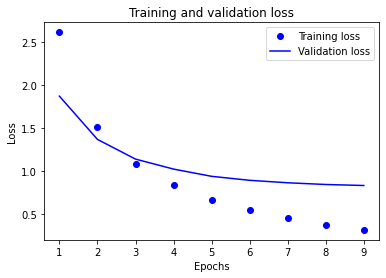

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the graph above we can see that despite it being similar to the model above, the training dataset and validation data set are getting closer to each other. By removing one of the 64 dimensional hidden layers, the validation loss has decreased from 94% at epoch 9 from model 3, to now being at 83% at epoch 9 for this model. Despite it still overfitting, this shows progress for the validation loss and performance is getting better.

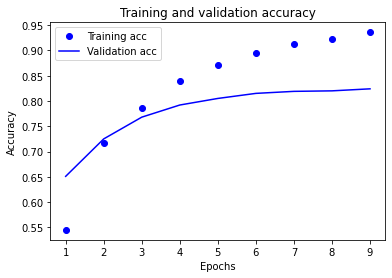

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy for this model is very similar to model 3. The training accuracy is slightly reduced, from 94% to 93% by epoch 9. The validation accuracy has slightly increased which shows some performance increases, as it hits 82%, which it did not in model 2.

Overall removing one of the hidden layers, reduced validation loss as well as slightly increased validation accuracy, resulting in better performance, despite it still being overfitting.


## Model 5 - Adding dropout
Using the same layer units and number of epochs as the first model, I decided to add dropout to the first two layers to see the results. Dropout set to 0.5. 


In [25]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(partial_x_train,
            partial_y_train,
            epochs=20,
            batch_size=512,
            validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
16/16 [==============================] - 0s 31ms/step - loss: 2.9982 - accuracy: 0.3642 - val_loss: 2.0059 - val_accuracy: 0.5530
Epoch 2/20
16/16 [==============================] - 0s 21ms/step - loss: 2.0268 - accuracy: 0.5373 - val_loss: 1.5814 - val_accuracy: 0.6420
Epoch 3/20
16/16 [==============================] - 0s 21ms/step - loss: 1.7043 - accuracy: 0.6024 - val_loss: 1.4068 - val_accuracy: 0.6650
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 1.4991 - accuracy: 0.6443 - val_loss: 1.2955 - val_accuracy: 0.6920
Epoch 5/20
16/16 [==============================] - 0s 21ms/step - loss: 1.3880 - accuracy: 0.6673 - val_loss: 1.2387 - val_accuracy: 0.7090
Epoch 6/20
16/16 [==============================] - 0s 21ms/step - loss: 1.2897 - accuracy: 0.6932 - val_loss: 1.1845 - val_accuracy: 0.7240
Epoch 7/20
16/16 [==============================] - 0s 22ms/step - loss: 1.2137 - accuracy: 0.7102 - val_loss: 1.1344 - val_accuracy: 0.7360
Epoch 8/20
16

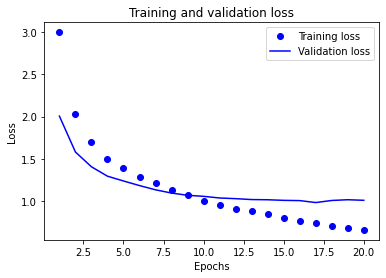

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph above is extremely different from the graphs we have seen above. After adding dropout rates at 0.5 for the first two hidden layers, it seemingly created a good graph, due to the training loss and validation loss being very close, however the training loss is considerably higher than previous models at 66%, whereas in Model 1, the training loss reached 10%, However the validation loss remained almost identical to the first model. therefore performance of the model was greatly affected.

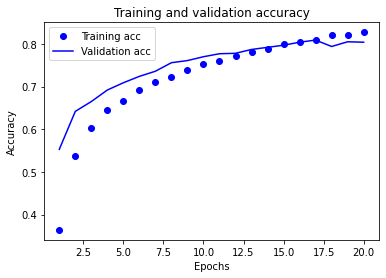

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Similarly to the loss graph, the datasets for the training and validation accuracy are very close compared to other models. This is due to adding dropouts which in return created a good graph, however the training accuracy was affected, as it reached almost 96% in the first model, and only reached 83% in this model. This is a similar case to the loss graph, where a good graph was created at the price of a lower performance.

## Experiment 6 - Removing Layer and Decreasing dropout rate 
Decreasing Dropout with 1 hidden layer, trying to reduce validation loss

In [36]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.2))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(partial_x_train,
            partial_y_train,
            epochs=20,
            batch_size=128,
            validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
63/63 [==============================] - 1s 14ms/step - loss: 1.9765 - accuracy: 0.6204 - val_loss: 1.2730 - val_accuracy: 0.7260
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 1.0590 - accuracy: 0.7725 - val_loss: 1.0164 - val_accuracy: 0.7900
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 0.7652 - accuracy: 0.8354 - val_loss: 0.9027 - val_accuracy: 0.8170
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 0.5835 - accuracy: 0.8789 - val_loss: 0.8433 - val_accuracy: 0.8240
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 0.4514 - accuracy: 0.9052 - val_loss: 0.8095 - val_accuracy: 0.8310
Epoch 6/20
63/63 [==============================] - 1s 12ms/step - loss: 0.3522 - accuracy: 0.9248 - val_loss: 0.8102 - val_accuracy: 0.8330
Epoch 7/20
63/63 [==============================] - 1s 12ms/step - loss: 0.2982 - accuracy: 0.9342 - val_loss: 0.7988 - val_accuracy: 0.8370
Epoch 8/20
63

For this model, we removed one hidden layer as my previous model with one hidden layer had good performance, pairing this with the dropout model, however this time reducing the dropout to 0.2, we was hoping that the validation loss was reduced.

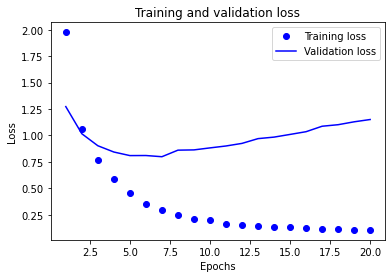

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss for this model improved greatly, as it was now at 10%, rather than 60%. The validation loss also hit a new low, at just below 80%, at epoch 7, however it then started to increase each epoch, making this an overfitting graph.

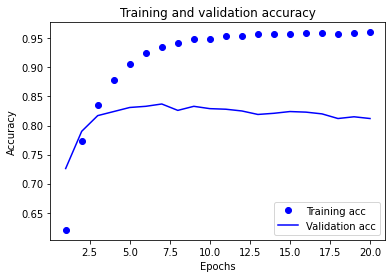

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy also greatly improved, as it reached 96%, compared to 82%, from the previous model. The validation accuracy peaked at 83% very early on at epoch 5, and then started to decrease or hit 83% again each epoch, making this an overfitting graph.

## Model 7 - L1 and L2 Regularisation 
Using the first model, but now adding L1 and L2 regularisation at 0.001.

In [28]:
from keras import regularizers
model = models.Sequential()
model.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu', input_shape=(10000,)))

model.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))

model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(partial_x_train,
            partial_y_train,
            epochs=20,
            batch_size=512,
            validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
16/16 [==============================] - 1s 34ms/step - loss: 6.0705 - accuracy: 0.4922 - val_loss: 3.1643 - val_accuracy: 0.5530
Epoch 2/20
16/16 [==============================] - 0s 24ms/step - loss: 2.8931 - accuracy: 0.5892 - val_loss: 2.6947 - val_accuracy: 0.6290
Epoch 3/20
16/16 [==============================] - 0s 23ms/step - loss: 2.6000 - accuracy: 0.6458 - val_loss: 2.5063 - val_accuracy: 0.6680
Epoch 4/20
16/16 [==============================] - 0s 23ms/step - loss: 2.4456 - accuracy: 0.6749 - val_loss: 2.3991 - val_accuracy: 0.6890
Epoch 5/20
16/16 [==============================] - 0s 24ms/step - loss: 2.3462 - accuracy: 0.6868 - val_loss: 2.2913 - val_accuracy: 0.6880
Epoch 6/20
16/16 [==============================] - 0s 24ms/step - loss: 2.2568 - accuracy: 0.6946 - val_loss: 2.2198 - val_accuracy: 0.6860
Epoch 7/20
16/16 [==============================] - 0s 25ms/step - loss: 2.1940 - accuracy: 0.6964 - val_loss: 2.1594 - val_accuracy: 0.6990
Epoch 8/20
16

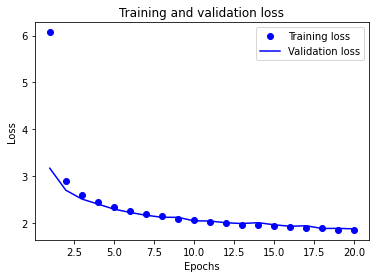

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Adding L1 and L2 regularisation created the best graphs, the loss for the training and validation data set were almost identical as you can see from the graph above. However, performance was greatly affected as both losses reached above 180%, making it the highest loss percentage out of all the models.

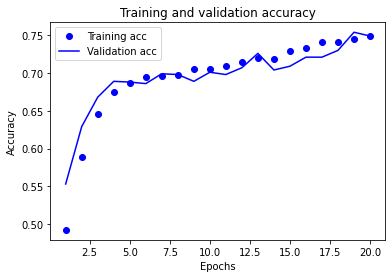

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Adding L1 and L2 regularisation also created a good graph for the training and validation accuracy, however similarly to the loss graph, performance was affected a lot. The training accuracy only reached 74% and the validation accuracy peaked at 75% at epoch 19, a significant decrease from other models, where we was able to reach over 93% training accuracy in all models besides model 5, where it still peaked at 82%, and atleast 80% validation accuracy in every other model.

# Conclusion and Evaluation

After looking at my models, it is clear that some models are better than others depending on what you are focusing on. The model with the greatest accuracy was model 4 - removing layers. Here we ran the model at 9 epochs and reached 82% validation accuracy at 9 epochs, however model 6 peaked at 83% validation accuracy early on, although this figure decreased in the following epochs. Model 4 also had the best validation loss, where it reached 83% at 9 epochs, however model 6 peaked at 79% validation loss at epoch 7, but this figure decreased as it reached 20 epochs.

Going off the graphs alone, model 7 produced the best graphs, where validation and training loss/accuracy were almost identical creating a good graph, however we would not use this model due to the extremely high validation loss rate at over 180% and low validation accuracy rate, at 75%. We would pick model 4 as my best model due to the loss and accuracy rate, in which it performed well in both, compared to the other models.
